## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

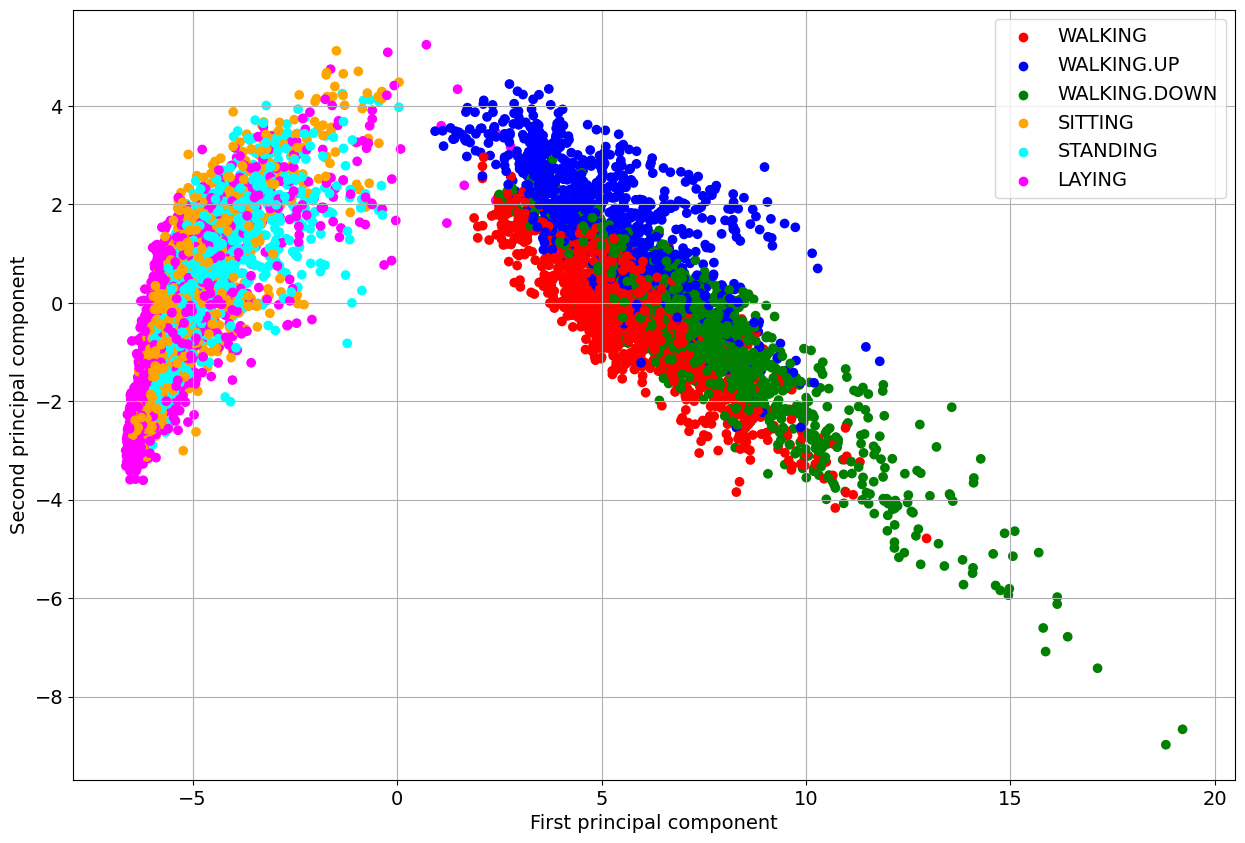

In [3]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [4]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [5]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

-------

## Прежде чем мы начнем.

Сама задача с HAR - типовая, и подразумевает собою Time-Series анализ пакетов и построение модели глубокого обучения с упором на анализ временных рядов. Традиционно для этого используется 2 типа моделей глубокого обучения: 

1. Модели со слоями долгой-краткосрочной памяти (LSTM).
2. Модели со слоями GRU.

LSTM модели больше подходят для анализа длительных цепочек событий, так как из за своей структуры способны цеплять малозаметные зависимости на большой дистанции, в то время как GRU - наоборот, используются для краткосрочных цепочек.

В данной работе изначально была цель построить модель глубокого обучения на LSTM слоях из за повышенной любви к ним, однако (спойлер), пришлось перейти к GRU слоям для достижения наибольшего результата.

Исходя из поставленной задачи анализа краткосрочных временных рядов, изначальная структура была выбрана такой, которая показана в демонстрации первой попытки получения максимального результата, а именно - простейшая комбинированная LSTM-based модель глубокого обучения с Dropout слоями.

-------

## Попытка №1

Традиционно, для работы с данными было принято решение начать с их визуализации. Был составлен график распределения классов для детекции, дабы убедиться, что нет дисбаланса используемых классов. Как видно из первого графика, дисбаланс классов отсутствует, что положительно скажется на детекте активностей в будущем.

In [6]:
import plotly.express as px


fig = px.pie(y_train_list,
             names=legend_labels,
             title='Distribution of Attack Labels'
             )
fig.show()

Далее было принято решение составить графики координат каждой из активностей исходя из данных гироскопа и акселерометра. Так как загруженные данные уже предобработаны, и не предоставляются в нужном нам формате в представленном ноутбуке изначально, мы загрузим их вручную.

In [7]:
raw_acc_x  = np.loadtxt('UCI HAR Dataset/train/Inertial Signals/body_acc_x_train.txt')
raw_acc_y  = np.loadtxt('UCI HAR Dataset/train/Inertial Signals/body_acc_y_train.txt')
raw_acc_z  = np.loadtxt('UCI HAR Dataset/train/Inertial Signals/body_acc_z_train.txt')
raw_gyro_x = np.loadtxt('UCI HAR Dataset/train/Inertial Signals/body_gyro_x_train.txt')
raw_gyro_y = np.loadtxt('UCI HAR Dataset/train/Inertial Signals/body_gyro_y_train.txt')
raw_gyro_z = np.loadtxt('UCI HAR Dataset/train/Inertial Signals/body_gyro_z_train.txt')

Затем опишем пару сервисных методов для вывода графиков.

In [8]:
def _hidden_plotter(plot_obj, x, y, z, activity, activity_idx, title, num_labels, pos):
    plot_obj.subplot(num_labels, 2, activity_idx * 2 + pos)
    plot_obj.plot(x, label='x', color='blue')
    plot_obj.plot(y, label='y', color='yellow')
    plot_obj.plot(z, label='z', color='green')
    plot_obj.title(f'{title} data for {activity.lower()}.')
    plot_obj.xlabel('Iter per batch.')
    plot_obj.ylabel('Coords value.')
    plot_obj.grid(True)
    plot_obj.legend(loc='upper left')
    return plot_obj


def _print_gyro(plot_obj, x, y, z, activity, activity_idx, num_labels = n_classes):
    return _hidden_plotter(plot_obj, x, y, z, activity, activity_idx, 'Gyroscope', num_labels, 2)


def _print_acceleometer(plot_obj, x, y, z, activity, activity_idx, num_labels = n_classes):
    return _hidden_plotter(plot_obj, x, y, z, activity, activity_idx, 'Accelerometer', num_labels, 1)


def plotter(label: int,
            metainfo: list[int],
            x_accelerometer: np.ndarray,
            y_accelerometer: np.ndarray,
            z_accelerometer: np.ndarray,
            x_gyroscope: np.ndarray,
            y_gyroscope: np.ndarray,
            z_gyroscope: np.ndarray) -> None:

    plt.figure(figsize=(15, 18))
    label_int, sample_row = metainfo[0], metainfo[1]

    plt_obj = _print_acceleometer(plot_obj=plt,
                                  x=x_accelerometer[sample_row],
                                  y=y_accelerometer[sample_row],
                                  z=z_accelerometer[sample_row],
                                  activity=label,
                                  activity_idx=label_int)

    plt_obj = _print_gyro(plot_obj=plt_obj,
                          x=x_gyroscope[sample_row],
                          y=y_gyroscope[sample_row],
                          z=z_gyroscope[sample_row],
                          activity=label,
                          activity_idx=label_int)

    plt_obj.tight_layout()
    plt_obj.show()
    

Сгенерим дикт следующего формата:

```json
{
    "Активность": [id активности, id строки с представленной активностью]
}
```

Как видно из графиков, большая часть активностей имеет разнородную структуру, однако, потенциально, будут проблемы с различием sitting и standing из за их некоторой сходности по координатам Y и X в акселерометре и в гироскопе. (Спойлер - они были)

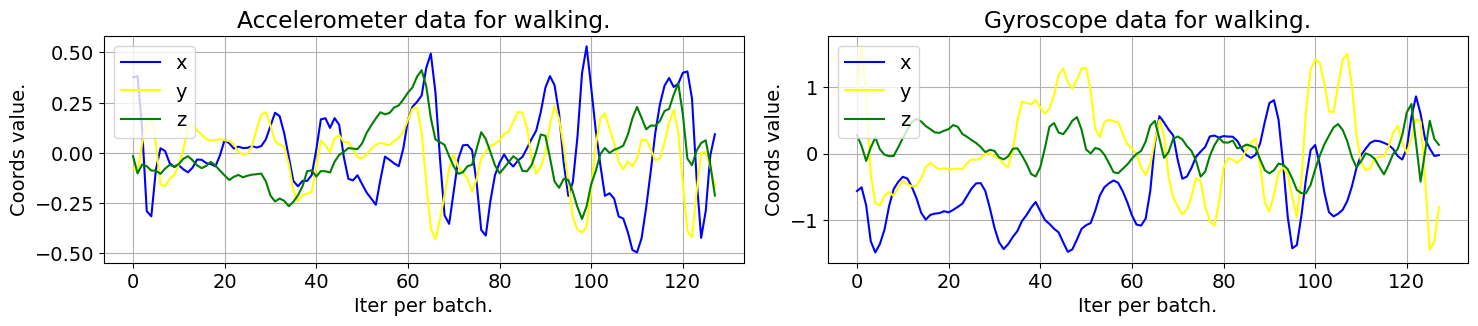

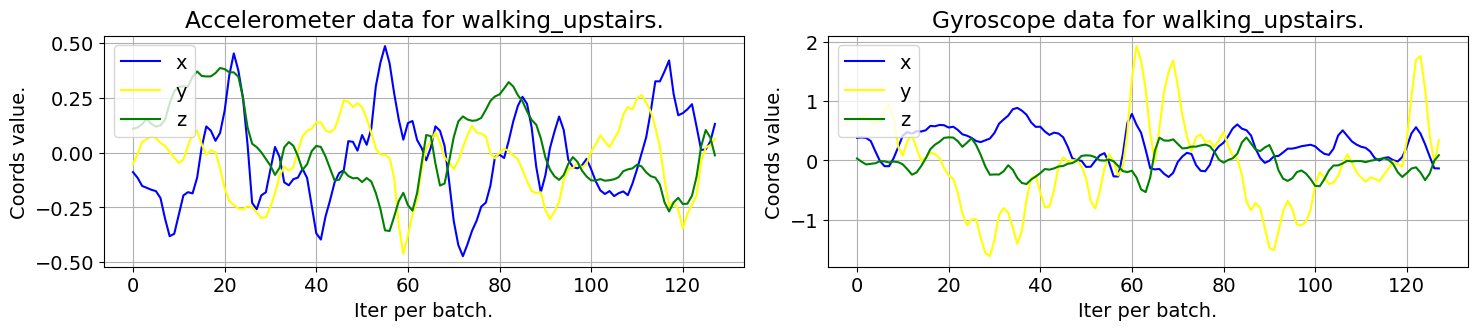

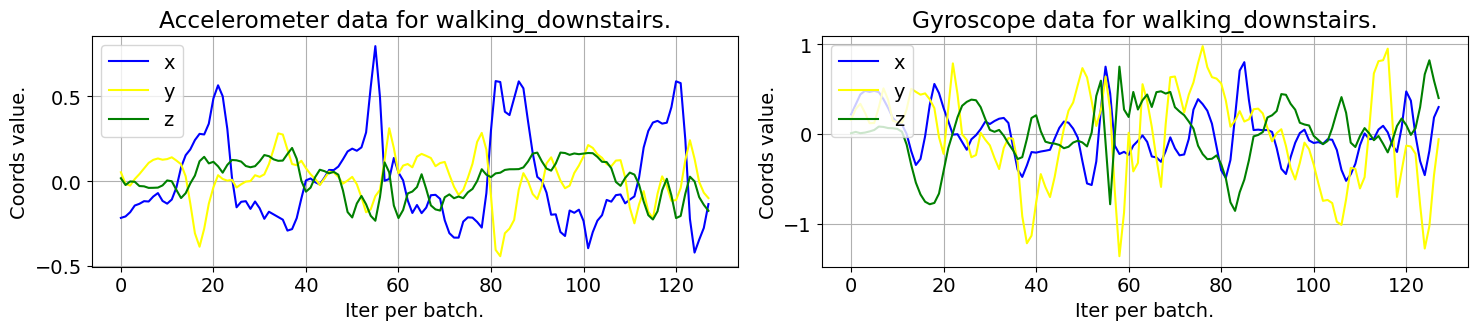

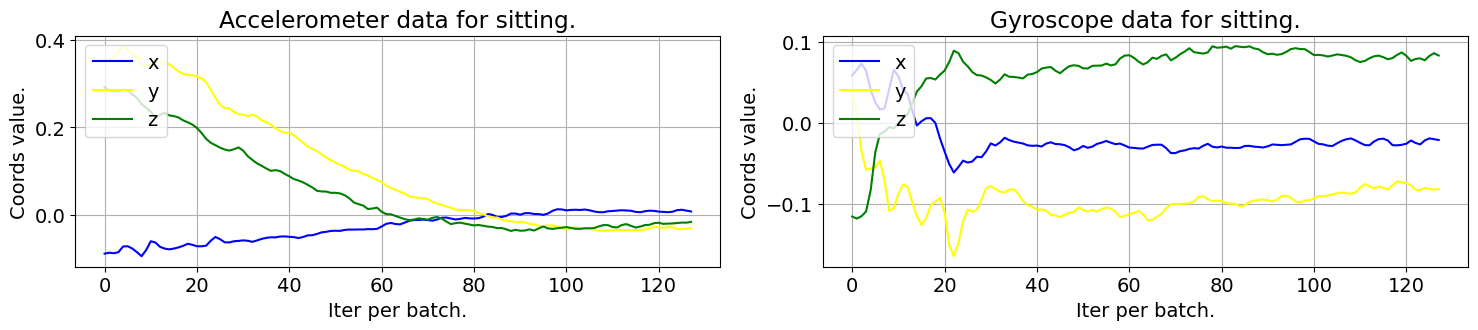

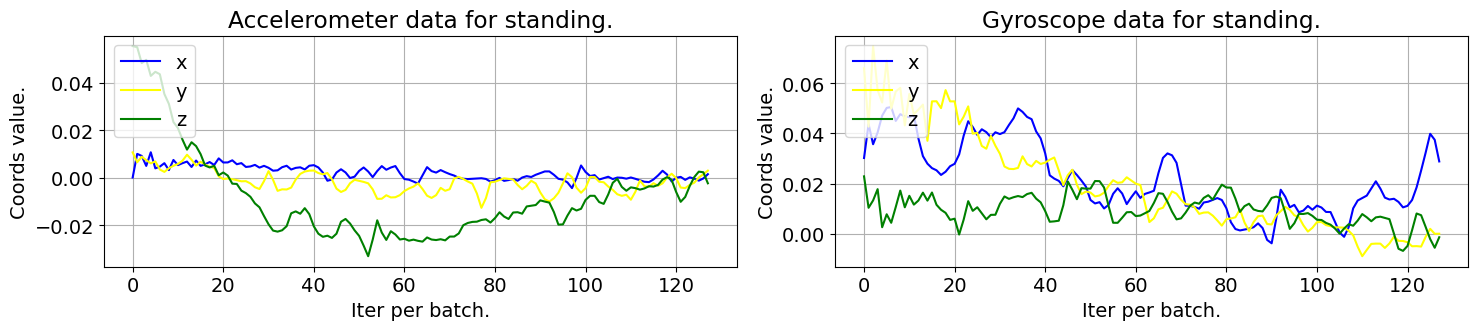

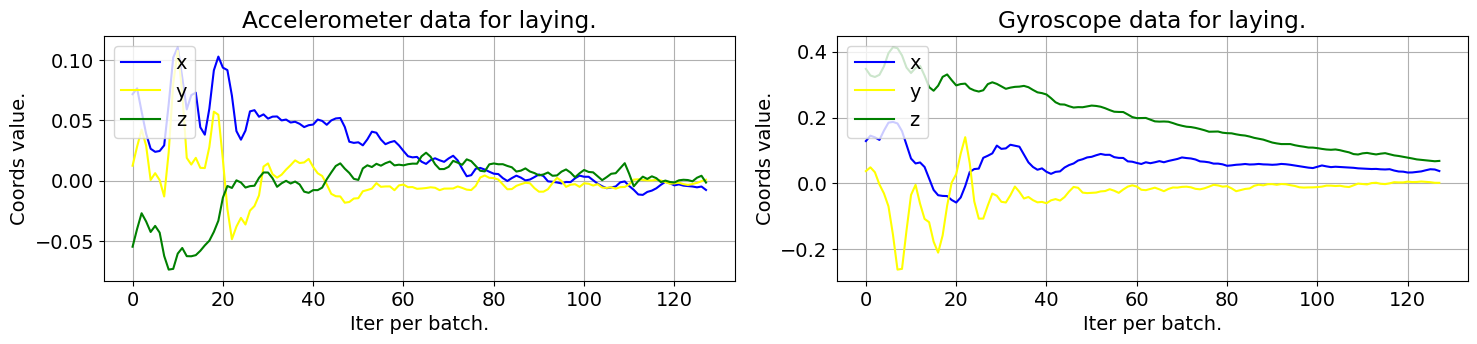

In [9]:
samples_idx = {label: [idx, np.where(y_train == idx)[0][0]] for idx, label in enumerate(LABELS)}

for key, val in samples_idx.items():
    plotter(key,
            val,
            raw_acc_x,
            raw_acc_y,
            raw_acc_z,
            raw_gyro_x,
            raw_gyro_y,
            raw_gyro_z)

In [10]:
del raw_acc_x
del raw_acc_y
del raw_acc_z
del raw_gyro_x
del raw_gyro_y
del raw_gyro_z

В итоге базовая модель состоит из двух LSTM слоев с 60/30 нейронами, а также стандартными для многоклассовой классификации функцией потерь `sparse_categorical_crossentropy`, оптимизатором `Adam`, и функцией активации `softmax`.

In [11]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Input, Dropout
from keras.callbacks import EarlyStopping


def build_model(X: np.ndarray,
                classes: int) -> Sequential:
    model = Sequential()
    model.add(Input(shape=(X.shape[1], X.shape[-1])))
    model.add(LSTM(units=60, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=30))
    model.add(Dropout(0.2))
    model.add(Dense(classes, activation="softmax", name="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer='Adam', metrics=['acc'])
    model.summary()
    return model


early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               min_delta=0.003,
                               restore_best_weights=True
                               )

model = build_model(X=X_train,
                    classes=n_classes)

history = model.fit(X_train,
                    y_train,
                    epochs=300,
                    batch_size=512,
                    verbose=1,
                    validation_split=0.2,
                    callbacks=[early_stopping]
                    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 60)           16800     
                                                                 
 dropout (Dropout)           (None, 128, 60)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30)                10920     
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 softmax (Dense)             (None, 6)                 186       
                                                                 
Total params: 27906 (109.01 KB)
Trainable params: 27906 (109.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/300
12/12 

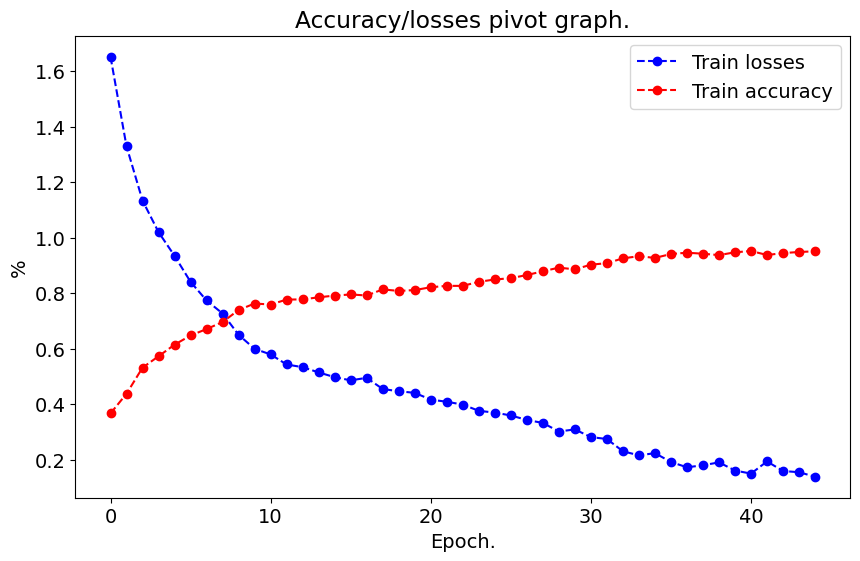

In [12]:
def hl_plot(history: dict):
    plt.figure(figsize=(10, 6))

    plt.plot(history['loss'],
            marker='o',
            linestyle='--',
            color='blue',
            label='Train losses')

    plt.plot(history['acc'],
            marker='o',
            linestyle='--',
            color='red',
            label='Train accuracy')

    plt.xlabel('Epoch.')
    plt.ylabel('%')
    plt.legend()
    plt.title('Accuracy/losses pivot graph.')
    plt.show()


hl_plot(history.history)

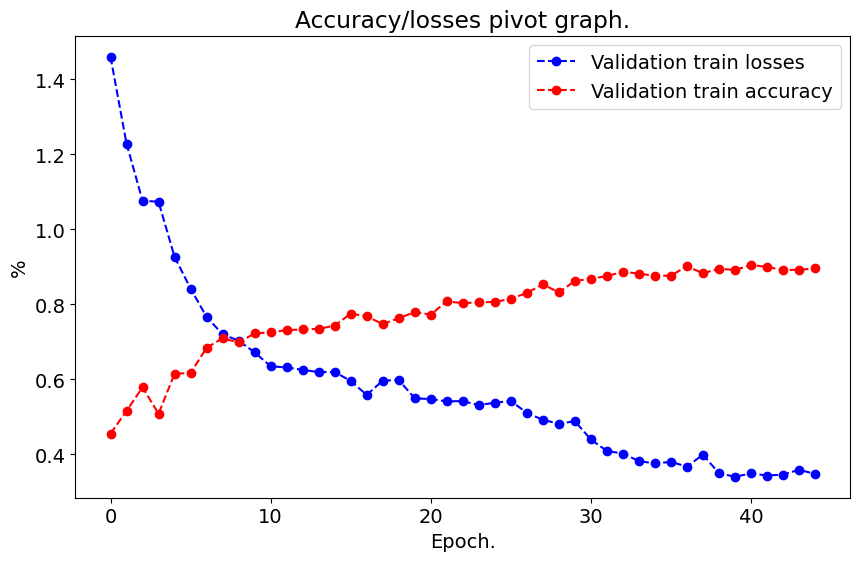

In [13]:
def hl_plot(history: dict):
    plt.figure(figsize=(10, 6))

    plt.plot(history['val_loss'],
            marker='o',
            linestyle='--',
            color='blue',
            label='Validation train losses')

    plt.plot(history['val_acc'],
            marker='o',
            linestyle='--',
            color='red',
            label='Validation train accuracy')

    plt.xlabel('Epoch.')
    plt.ylabel('%')
    plt.legend()
    plt.title('Accuracy/losses pivot graph.')
    plt.show()


hl_plot(history.history)

In [14]:
def predictor(data:np.array, model:Sequential) -> np.array:
    y_pred_prob = model.predict(data)
    y_pred = np.argmax(y_pred_prob, axis=1)
    return y_pred

y_pred = predictor(data=X_test, model=model)

93/93 [==============================] - 1s 10ms/step


Как видно из матрицы зависимостей, большая часть проблем с детектом на тестовых данных связана с определением класса SITTING и STANDING, количество FP/FN на них высоко по сравнению с другими классами.

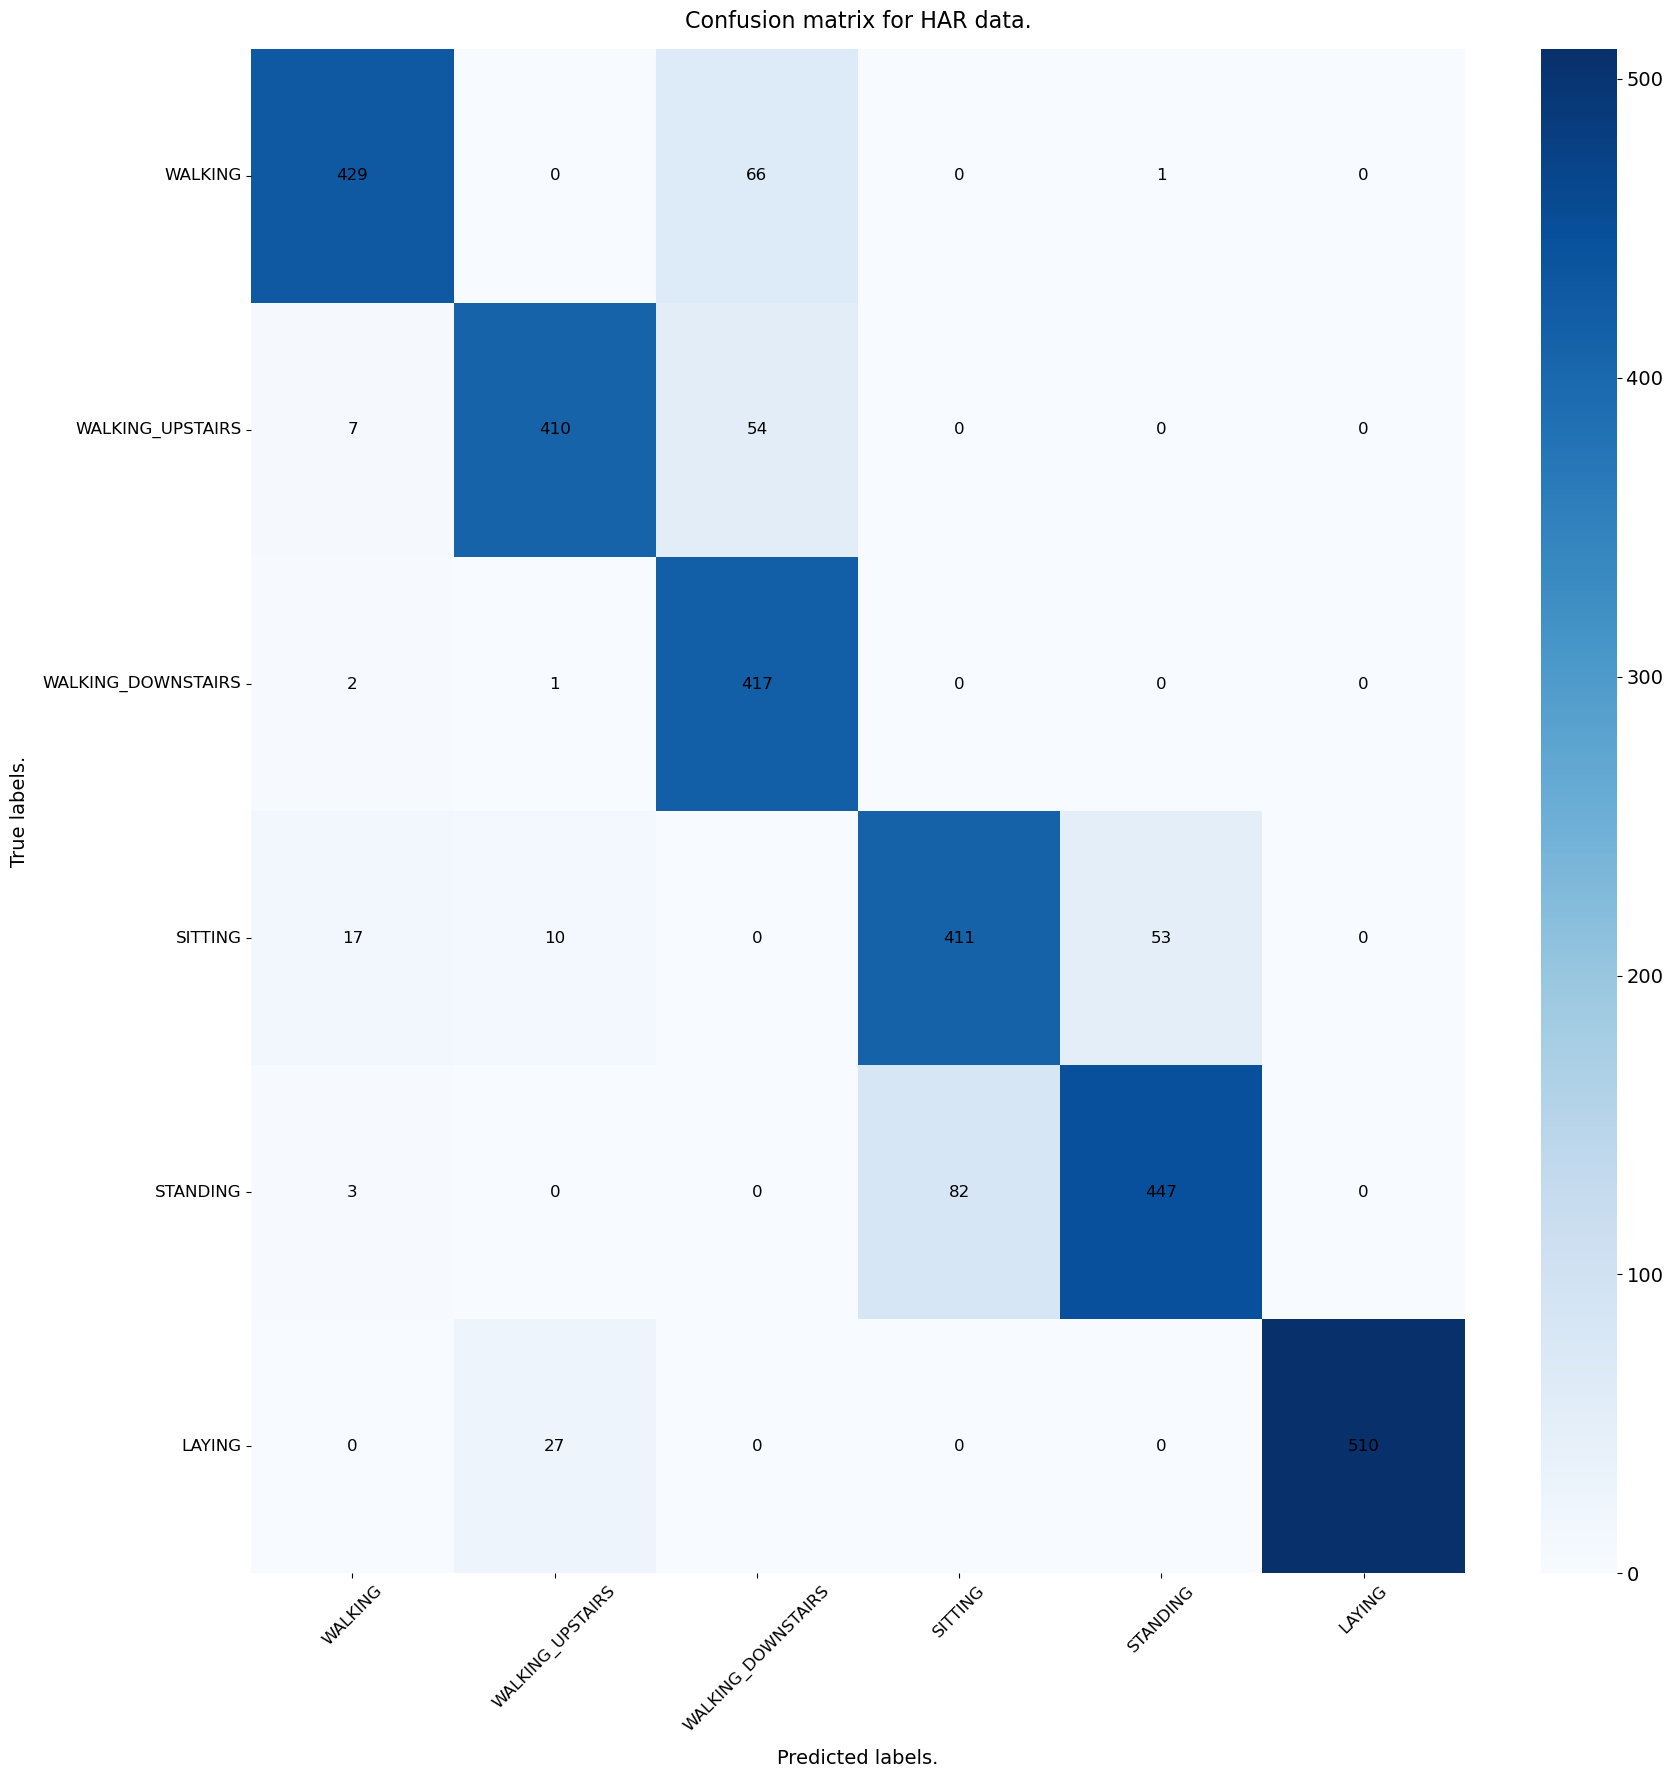

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def c_matrix(preds, true_labels):
    plt.figure(figsize=(18, 18))
    cm = confusion_matrix(y_pred=preds, y_true=true_labels)

    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                cbar=True,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot_kws={"size": 12,
                           "color": "black"
                           })

    plt.title('Confusion matrix for HAR data.', fontsize=16, pad=15)
    plt.xlabel('Predicted labels.', fontsize=14, labelpad=10)
    plt.ylabel('True labels.', fontsize=14, labelpad=10)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()


c_matrix(preds=y_pred,
         true_labels=y_test)

In [16]:
from sklearn.metrics import classification_report


print(f'Classification report: {classification_report(y_test, y_pred)}')

Classification report:               precision    recall  f1-score   support

           0       0.94      0.86      0.90       496
           1       0.92      0.87      0.89       471
           2       0.78      0.99      0.87       420
           3       0.83      0.84      0.84       491
           4       0.89      0.84      0.87       532
           5       1.00      0.95      0.97       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.90      0.89      0.89      2947



А точность не достигает показателей максимального балла и остается в районе 87%. Дальнейшие тесты и эксперименты будут посвящены модификации неподходящей LSTM модели для достижения максимального балла.

------

## Попытка №2

Наибольший буст точности придало использование StandartScaler`a. Так как данные имеют разный масштаб, модели приходилось бороться с их разницей, что снижало ее способность улавливать паттерны. В итоге за счет внедрения StandartScalerа была ускоренна сходимость, мы избежали доминации одних признаков над другими и избежали перенасыщения функций активации. Однако точности в 89% все-равно не хватает для получения высшего балла.

In [17]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

Что было испробовано:

1. Добавление крупного LSTM слоя на 120 нейронов - повышение точности.
2. Введение l2 регуляризации - понижение точности.
3. Введение Dropout слоя после 120-нейронного LSTM - понижение.
4. Изменение Dropout с 0.2 до 0.3 - повышение.
5. Изменение batch-size с 512 до 1024 - существенное понижение.
6. С 1024 до 256 - нет изменений относительно 512.
7. Добавление Bidirectional обертки - FP повысился, FN снизился, общий результат не изменился.

Топ результат на неподходящей для данной задачи LSTM-ке - 92%.

Сдаемся, переходим на GRU.

1. Замена LSTM на GRU - 92%.
2. Психуем, идем в ва-банк. Повышаем нейроны в GRU слоях до 200/100/50 + накидываем еще слой на 30. Тюним Dropout до 0.4, накидываем batchnorm для стабилизации обучения - 90%..................
3. Идем в еще больший ва-банк, накидываем сверточных слоев для извлечения локальных признаков, что должно помочь GRU слоям легче извлекать зависимости - 92%.
4. Смотрим в задачу, видим, что на макс балл нужен 91%. Орём............................................ Возвращаем всё как было.

In [18]:
from keras.layers import GRU, Bidirectional, BatchNormalization, Conv1D, MaxPooling1D


def build_model(X: np.ndarray,
                classes: int) -> Sequential:
    model = Sequential()
    model.add(Input(shape=(X.shape[1], X.shape[-1])))
    model.add(LSTM(units=120, return_sequences=True))
    model.add(Bidirectional(LSTM(units=60, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(LSTM(units=30))
    model.add(Dropout(0.3))
    model.add(Dense(classes, activation="softmax", name="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer='Adam', metrics=['acc'])
    model.summary()
    return model


# def build_model(X: np.ndarray,
#                 classes: int) -> Sequential:
#     model = Sequential()
#     model.add(Input(shape=(X.shape[1], X.shape[-1])))
#     model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.3))
#     model.add(GRU(units=120, return_sequences=True))
#     model.add(BatchNormalization())
#     model.add(Bidirectional(GRU(units=60, return_sequences=True)))
#     model.add(Dropout(0.4))
#     model.add(GRU(units=30))
#     model.add(Dropout(0.4))
#     model.add(Dense(classes, activation="softmax", name="softmax"))
#     model.compile(loss="sparse_categorical_crossentropy", optimizer='Adam', metrics=['acc'])
#     model.summary()
#     return model


early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               min_delta=0.003,
                               restore_best_weights=True
                               )

model = build_model(X=X_train,
                    classes=n_classes)

history = model.fit(X_train,
                    y_train,
                    epochs=500,
                    batch_size=1024,
                    verbose=1,
                    validation_split=0.2,
                    callbacks=[early_stopping]
                    )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128, 120)          62400     
                                                                 
 bidirectional (Bidirection  (None, 128, 120)          86880     
 al)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 128, 120)          0         
                                                                 
 lstm_4 (LSTM)               (None, 30)                18120     
                                                                 
 dropout_3 (Dropout)         (None, 30)                0         
                                                                 
 softmax (Dense)             (None, 6)                 186       
                                                      

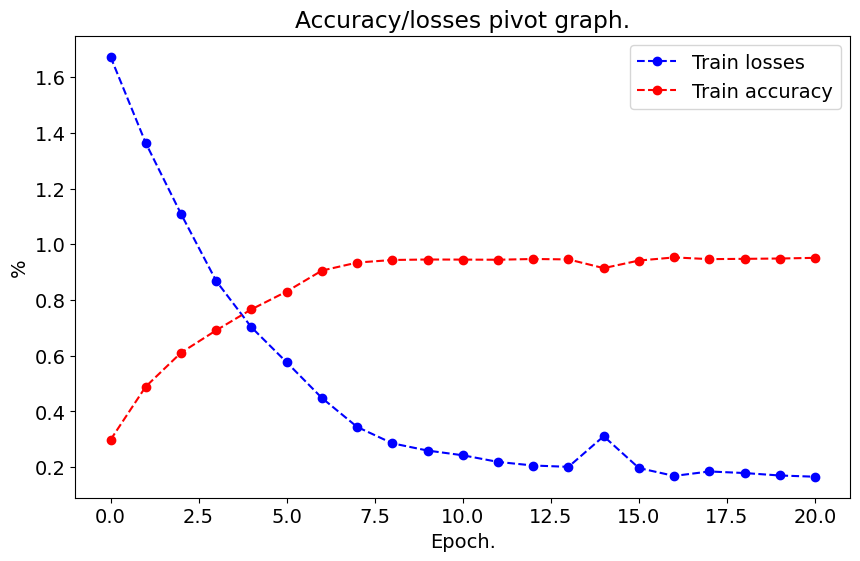

In [19]:
def hl_plot(history: dict):
    plt.figure(figsize=(10, 6))

    plt.plot(history['loss'],
            marker='o',
            linestyle='--',
            color='blue',
            label='Train losses')

    plt.plot(history['acc'],
            marker='o',
            linestyle='--',
            color='red',
            label='Train accuracy')

    plt.xlabel('Epoch.')
    plt.ylabel('%')
    plt.legend()
    plt.title('Accuracy/losses pivot graph.')
    plt.show()


hl_plot(history.history)

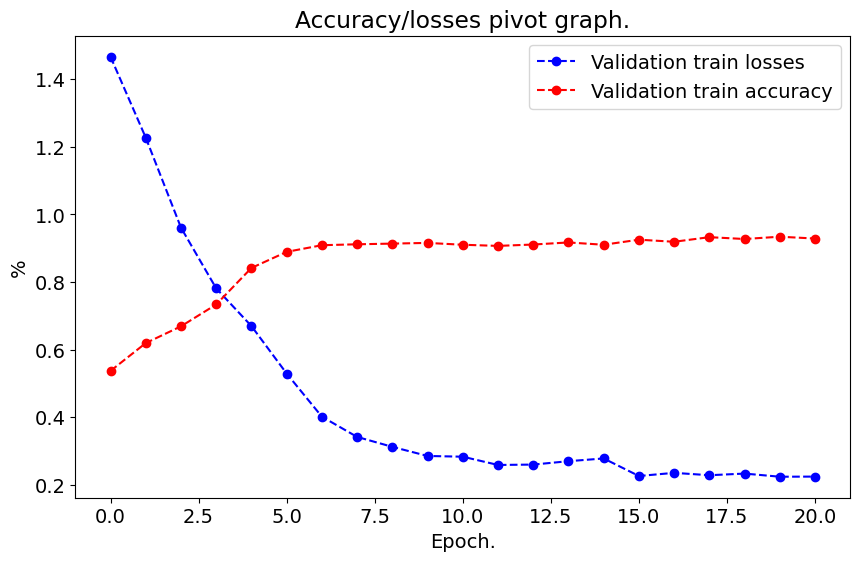

In [20]:
def hl_plot(history: dict):
    plt.figure(figsize=(10, 6))

    plt.plot(history['val_loss'],
            marker='o',
            linestyle='--',
            color='blue',
            label='Validation train losses')

    plt.plot(history['val_acc'],
            marker='o',
            linestyle='--',
            color='red',
            label='Validation train accuracy')

    plt.xlabel('Epoch.')
    plt.ylabel('%')
    plt.legend()
    plt.title('Accuracy/losses pivot graph.')
    plt.show()


hl_plot(history.history)

In [21]:
def predictor(data:np.array, model:Sequential) -> np.array:
    y_pred_prob = model.predict(data)
    y_pred = np.argmax(y_pred_prob, axis=1)
    return y_pred

y_pred = predictor(data=X_test, model=model)

93/93 [==============================] - 2s 14ms/step


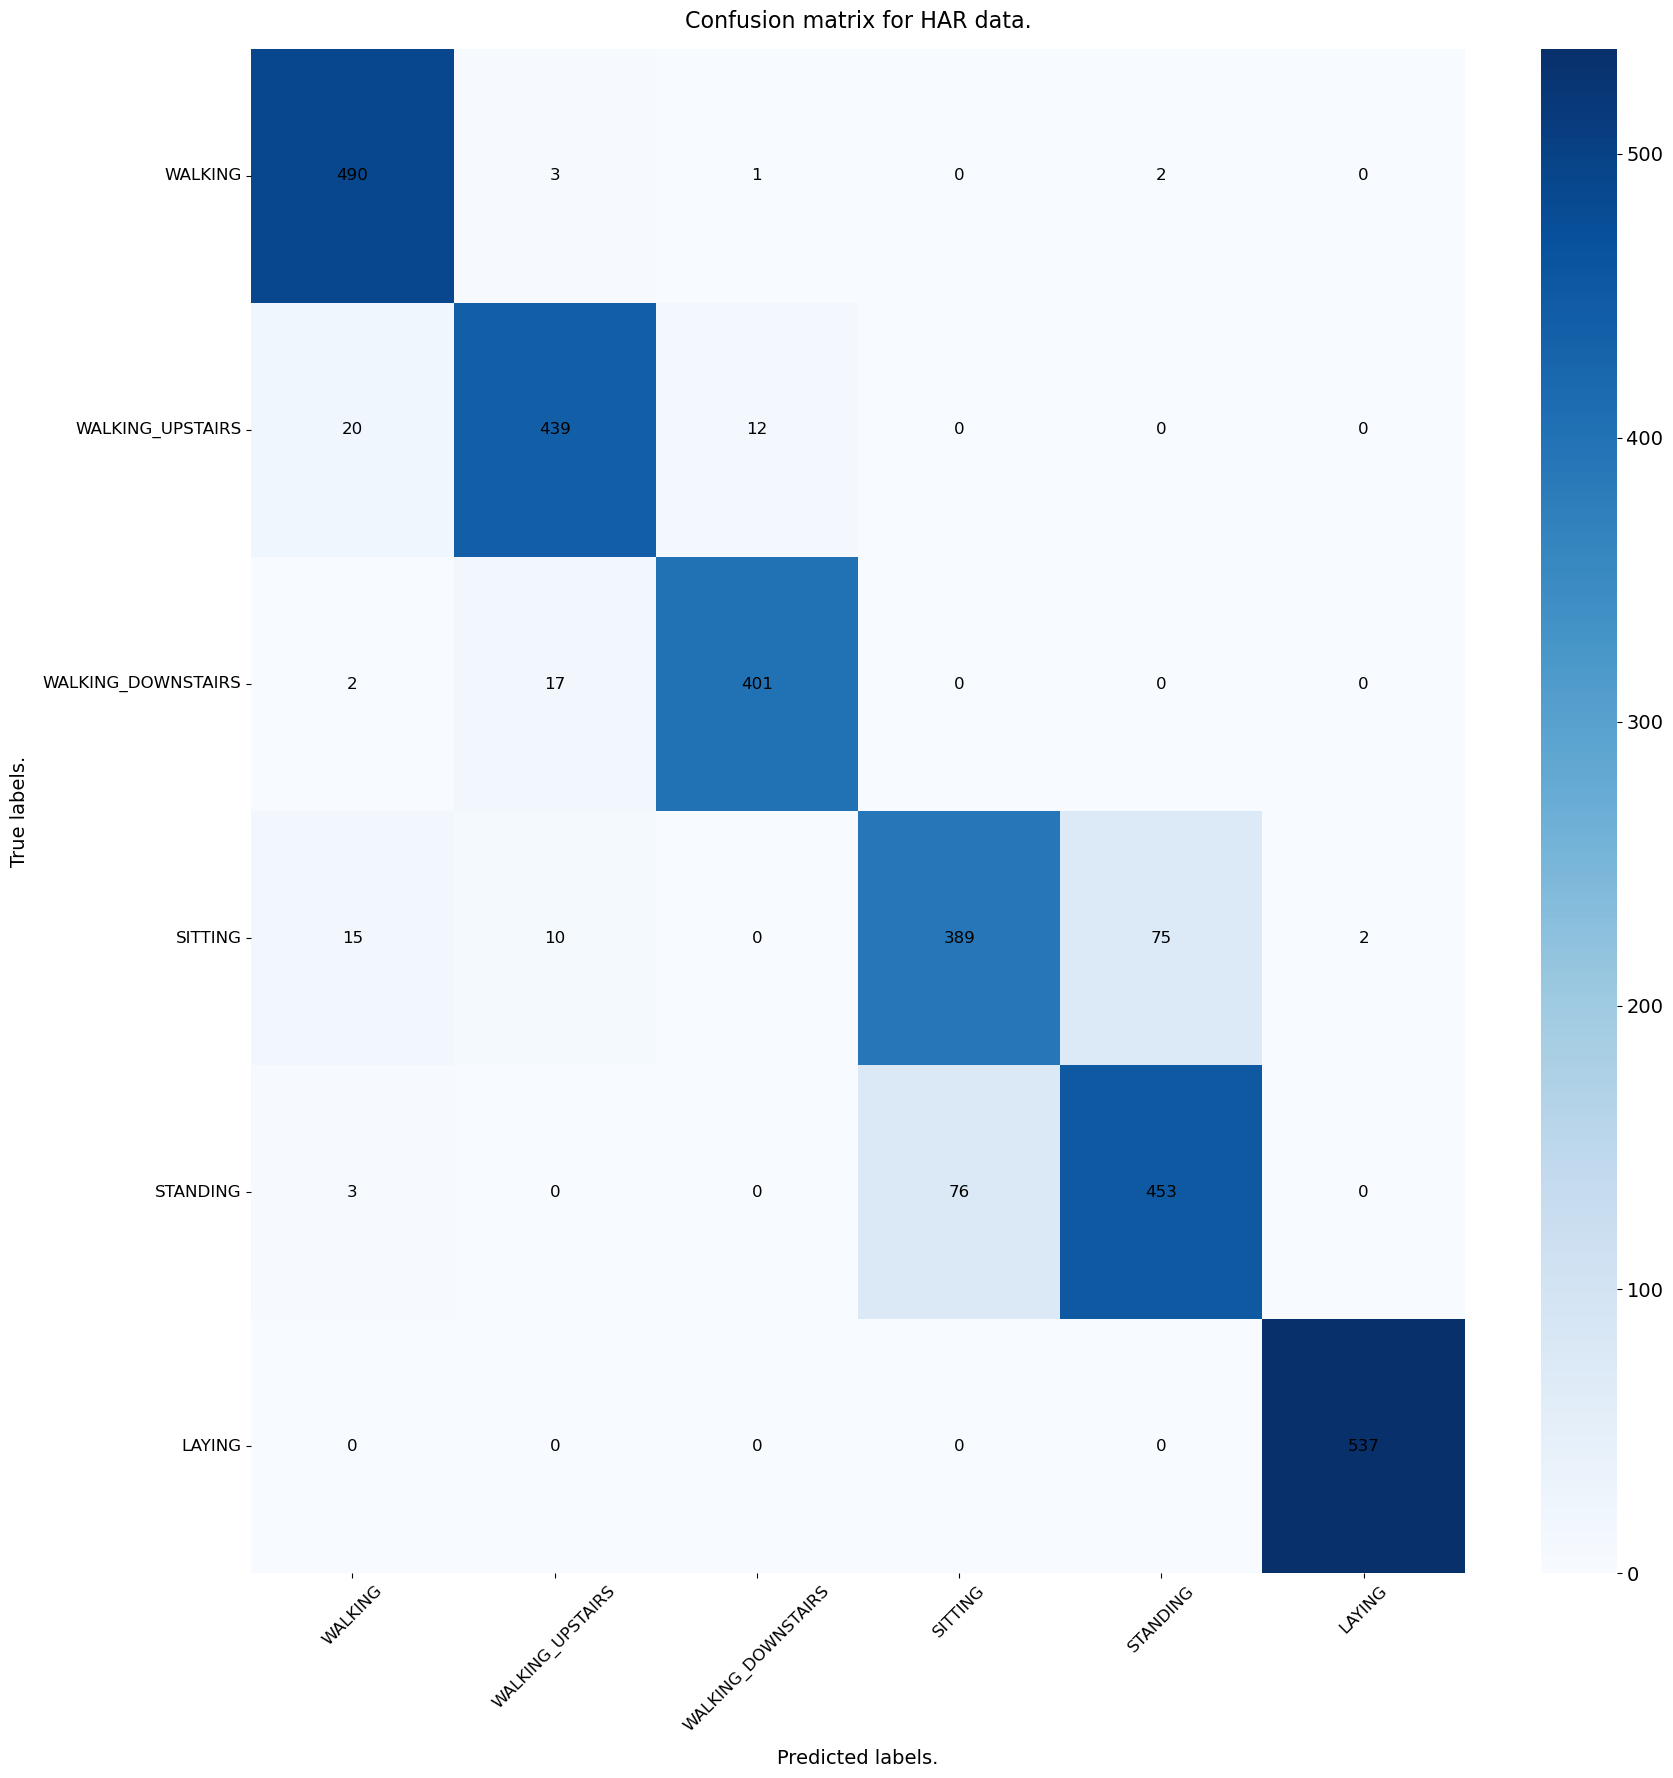

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def c_matrix(preds, true_labels):
    plt.figure(figsize=(18, 18))
    cm = confusion_matrix(y_pred=preds, y_true=true_labels)

    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap='Blues',
                cbar=True,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot_kws={"size": 12,
                           "color": "black"
                           })

    plt.title('Confusion matrix for HAR data.', fontsize=16, pad=15)
    plt.xlabel('Predicted labels.', fontsize=14, labelpad=10)
    plt.ylabel('True labels.', fontsize=14, labelpad=10)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()


c_matrix(preds=y_pred,
         true_labels=y_test)

In [23]:
from sklearn.metrics import classification_report


print(f'Classification report: {classification_report(y_test, y_pred)}')

Classification report:               precision    recall  f1-score   support

           0       0.92      0.99      0.96       496
           1       0.94      0.93      0.93       471
           2       0.97      0.95      0.96       420
           3       0.84      0.79      0.81       491
           4       0.85      0.85      0.85       532
           5       1.00      1.00      1.00       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



92%. Задача выполнена.

### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [24]:
# Your experiments here